<a href="https://colab.research.google.com/github/zinengtang/TVLT/blob/main/Demo_Emotional_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TVLT Emotional Analysis

This notebook demonstrates how to use TVLT for Emotional Analysis on Video-Audio inputs and on Video-Text inputs. (MOSEI dataset)

## Check GPU status

In [1]:
!nvidia-smi

Thu Sep 29 01:04:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download code and install dependencies

In [2]:
!git clone https://github.com/zinengtang/TVLT

fatal: destination path 'TVLT' already exists and is not an empty directory.


In [3]:
cd /content/TVLT

/content/TVLT


In [4]:
pwd

'/content/TVLT'

In [5]:
!pip install -q torch==1.10.0 torchvision==0.11.1 torchaudio==0.10.0 torchtext
!pip install -q -r requirements.txt
!pip install -q imageio==2.4.1

     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:42tcmalloc: large alloc 1147494400 bytes == 0x64b44000 @  0x7f8563fb7615 0x58e046 0x4f2e5e 0x4d19df 0x51b31c 0x5b41c5 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51837f 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4ba70a 0x538136 0x590055 0x51b180 0x5b41c5 0x58f49e 0x51837f 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x517947 0x5b41c5 0x58f49e
     |████████████████████████████████| 881.9 MB 19 kB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 2.9 MB 43.3 MB/s 
     |████████████████████████████████| 1.9 MB 52.9 MB/s 
     |████████████████████████████████| 10.4 MB 21.2 MB/s 
     |████████████████████████████████| 8.0 MB 12.8 MB/s 
     |████████████████████████████████| 8.0 MB 22.8 MB/s 
     |████████████████████████████████| 8.0 MB 56.9 MB/s 
     |████████████████████████████████| 585 kB 21.8 MB/s 
     |████████████████████████████████| 4.4 MB 46.6 MB/s 
     |███

### Load model for emotional analysis

In [6]:
from demos import MOSEI_emotion_model, MOSEI_emotion_model_text

model = MOSEI_emotion_model()
model_text = MOSEI_emotion_model_text()

# Be default, the model weight will be automatically downloaded into ~/.cache/huggingface/hub/models--TVLT--models/blobs
# The symbol link of the model will be in ~/.cache/huggingface/hub/models--TVLT--models/snapshots/5f9684296bcd0389ce6af252487f8b82e9170f2b/[the_checkpoint_symbol_link] -> ../../blobs/[the_actual_model_file]
# This is automatically handled by huggingface hub.

Downloading:   0%|          | 0.00/355M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/444M [00:00<?, ?B/s]

In [7]:
device = 'cuda'
# device  = 'cpu'

model.to(device)
model_text.to(device)

model.eval();
model_text.eval();

### Load sample data

In [8]:
from model.data.datasets.rawvideo_utils import load_audio, load_video, load_video_audio, load_text

video_path = 'demo_samples/MOSEI/K0m1tO3Ybyc_2.mp4' # You can specify your own video file here
audio_path = 'demo_samples/MOSEI/K0m1tO3Ybyc_2.wav' # You can specify your own audio file here
video = load_video(video_path, num_frames=8)
audio = load_audio(audio_path, sr=44100)

text_path = 'demo_samples/MOSEI/K0m1tO3Ybyc_2.txt' # You can specify your own text file here
text, text_ids, text_masks = load_text(text_path)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)606208/45929032 bytes (1.3%)1163264/45929032 bytes (2.5%)2433024/45929032 bytes (5.3%)6422528/45929032 bytes (14.0%)10584064/45929032 bytes (23.0%)14630912/45929032 bytes (31.9%)18669568/45929032 bytes (40.6%)22847488/45929032 bytes (49.7%)27115520/45929032 bytes (59.0%)31309824/45929032 bytes (68.2%)35373056/45929032 bytes (77.0%)39329792/45929032 bytes (85.6%)4349132

  "Argument interpolation should be of type InterpolationMode instead of int. "



Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Inference

In [9]:
video = video.to(device)
audio = audio.to(device)
text_ids = text_ids.to(device)
text_masks = text_masks.to(device)

In [10]:
import numpy as np
import torch

with torch.no_grad():
  encoder_last_hidden_outputs, *_ = model(video=video, audio=audio)
  s = model.classifier(encoder_last_hidden_outputs).squeeze().data.cpu().numpy()
  s = np.round(s, 3)

  encoder_last_hidden_outputs_text_based, *_ = model_text(video=video, text_ids=text_ids, text_masks=text_masks)
  s_t = model.classifier(encoder_last_hidden_outputs_text_based).squeeze().data.cpu().numpy()
  s_t = np.round(s_t, 3)

--------------------------
emotion intensity, by TVLT video-audio model
Happy 0.722 Sad -0.655 Angry 0.658 Fear 0.077 Disgust 0.747 Surprise -0.693
--------------------------
emotion intensity, by TVLT video-text model
Happy 0.789 Sad 0.246 Angry 0.613 Fear 0.177 Disgust -1.439 Surprise -0.884
--------------------------

Sample Display


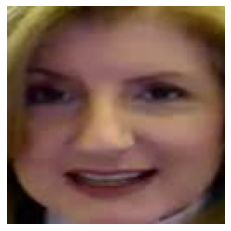

"Remember when we read about Marie Antoinette we used to talk of love."


In [11]:
import matplotlib.pyplot as plt
from model.data.datasets.rawvideo_utils import load_video_raw

print('--------------------------')
print('emotion intensity, by TVLT video-audio model')
print(f'Happy {str(s[0])} Sad {str(s[1])} Angry {str(s[2])} Fear {str(s[3])} Disgust {str(s[4])} Surprise {str(s[5])}')
print('--------------------------')
print('emotion intensity, by TVLT video-text model')
print(f'Happy {str(s_t[0])} Sad {str(s_t[1])} Angry {str(s_t[2])} Fear {str(s_t[3])} Disgust {str(s_t[4])} Surprise {str(s_t[5])}')

print('--------------------------')
print()
print('Sample Display')
plt.axis('off')
plt.imshow(load_video_raw(video_path, 3)[0])
plt.show()

print(f'"{text}"')

import IPython

IPython.display.Audio(audio_path)

### Note on shape of the tensor (Video-Audio Model)

* Dimension of input video tensor: (batch_size, number_of_frames, rgb_channel, width, height)  
* Dimension of input audio tensor: (batch_size, number_of_audio_channels, time, spectrogram)

See the actual size of the tensor below.

In [12]:
print(video.size())   # 1, 8, 3, 224, 224
print(audio.size())   # 1, 1, 432, 128

torch.Size([1, 8, 3, 224, 224])
torch.Size([1, 1, 432, 128])


We encoder the input video and audio using the transformer.

See the size of the hidden outputs below.

In [13]:
with torch.no_grad():
  encoder_last_hidden_outputs, *_ = model(video=video, audio=audio)
print(encoder_last_hidden_outputs.size())

torch.Size([1, 1785, 768])


We can see that we got a total number of **1785** features with dimension size being 768 (the hidden output size of TVLT encoder).

**How is 1785 added up?**

We split the input video frames into $16 \times 16$-sized patches and split input audio spectrogram into $16 \times 16$-sized patches.  

Given that we have $8$ frames of $224 \times 224$-images and the audio spectrogram is $432 \times 128$, we will have $8 \times \frac{224}{16} \times \frac{224}{16} = 1568$ video patches and $\frac{432}{16} \times \frac{128}{16} = 216 $ audio patches.

We apply transformer on each patch and then append a $[CLS]$ token at the beginning. That gives us a total number of $1 + 1568 + 216 = 1785$ features.

Finally, we apply MLP head on the first $[CLS]$ token. See the code below.

In [14]:
with torch.no_grad():
  emotional_score = model.classifier(encoder_last_hidden_outputs)
print(emotional_score)  # print the output score for Happy, Sad, Angry, Fear, Disgust, Surprise

tensor([[ 0.7224, -0.6551,  0.6578,  0.0768,  0.7466, -0.6933]],
       device='cuda:0')


### Note on shape of the tensor (Video-Text Model)

* Dimension of input video tensor: (batch_size, number_of_frames, rgb_channel, width, height)  
* Dimension of input audio tensor: (batch_size, number_of_tokens)

See the actual size of the tensor below.

In [15]:
print(video.size())   # 1, 8, 3, 224, 224
print(text_ids.size())   # 1, 1, 432, 128

torch.Size([1, 8, 3, 224, 224])
torch.Size([1, 40])


We encoder the input video and audio using the transformer.

See the size of the hidden outputs below.

In [16]:
with torch.no_grad():
  encoder_last_hidden_outputs_text_based, *_ = model_text(video=video, text_ids=text_ids, text_masks=text_masks)
print(encoder_last_hidden_outputs_text_based.size())

torch.Size([1, 1609, 768])


We can see that we got a total number of **1609** features with dimension size being 768 (the hidden output size of TVLT encoder).

**How is 1609 added up?**

Again, we split the input video frames into $16 \times 16$-sized patches.

We have $8$ frames of $224 \times 224$-images from video input and we have 40 tokens from text input. 
We will have $8 \times \frac{224}{16} \times \frac{224}{16} = 1568$ video patches and $40$ text tokens.

We apply transformer on each patch and token and then append a $[CLS]$ token at the beginning. That gives us a total number of $1 + 1568 + 40 = 1609$ features.

Finally, we apply MLP head on the first $[CLS]$ token. See the code below.

In [17]:
with torch.no_grad():
  emotional_score_t = model.classifier(encoder_last_hidden_outputs_text_based)
print(emotional_score_t)  # print the output score for Happy, Sad, Angry, Fear, Disgust, Surprise

tensor([[ 0.7892,  0.2465,  0.6133,  0.1766, -1.4388, -0.8844]],
       device='cuda:0')
